# 06_Advanced_Modality_Demand_Distribution_Analysis.ipynb

**Objective:** To model and analyze the age-based demand for CT, MRI, and Endoscopy across five distinct patient and service pathways. This notebook will use continuous age data (from 0 to max) to fit and evaluate various statistical distributions, providing a more granular understanding of demand patterns than traditional age-banded analysis. The ultimate goal is to identify the most appropriate statistical distributions to represent demand in each of the five defined models, which can then be used for forecasting and capacity planning.

## 1. Setup and Data Loading

This section imports necessary libraries and ingests data from the raw CSV files. It includes robust loading, cleaning, and mapping logic to create a standardized DataFrame for analysis.

In [1]:
# ---------------------------------------------------
# Step 1.1 – Imports & Raw-Folder Ingestion
# ---------------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re
from scipy import stats
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
sns.set_theme(style="whitegrid")

# --- Set directory path to raw NHS ICB files ---
raw_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs"

# --- Try loading data from raw folder ---
try:
    csv_files = glob.glob(os.path.join(raw_dir, "*.csv"))
    if not csv_files:
        raise FileNotFoundError("csv_files list is empty – check the 'raw_dir' path.")
except FileNotFoundError as e:
    print(e)
    print("Creating a sample DataFrame for demonstration purposes.")
    # Create a fallback dataframe if data loading fails
    df = pd.DataFrame({
        'age': np.random.randint(0, 100, 5000),
        'modality': np.random.choice(['Computerized axial tomography (procedure)', 'Magnetic resonance imaging (procedure)', 'Endoscopy (procedure)'], size=5000),
        'patient_source': np.random.choice(['accident & emergency department', 'gp direct access service', 'inpatient', 'outpatient'], size=5000),
        'cancer_flag': np.random.choice([True, False], size=5000, p=[0.1, 0.9])
    })
else:
    print(f"Detected {len(csv_files)} files to load.")
    expected_cols = [
        'icb_code','icb_name','lsoa_code','nhs_region', 'site_code','site_name','provider_code','provider_name',
        'activity_month','financial_year','financial_month','test_date', 'age','sex','modality','sub_modality','procedure_name',
        'referral_type','patient_source','cancer_flag','subcancer_flag', 'referring_org_code','referring_org_name'
    ]
    dfs, meta = [], []
    for fp in csv_files:
        try:
            peek = pd.read_csv(fp, nrows=5, low_memory=False)
            if not set(expected_cols).issubset(peek.columns):
                df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
            else:
                df_tmp = pd.read_csv(fp, low_memory=False)
            df_tmp = df_tmp.dropna(axis=1, how='all')
            df_tmp.columns = df_tmp.columns.str.strip().str.lower()
            df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
            for col in (set(expected_cols) - set(df_tmp.columns)):
                df_tmp[col] = pd.NA
            df_tmp = df_tmp[expected_cols]
            dfs.append(df_tmp)
            meta.append({
                "file": os.path.basename(fp), "rows": len(df_tmp),
                "cols": df_tmp.shape[1], "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
            })
        except Exception as e:
            print(f"Error loading file {os.path.basename(fp)}: {e}")
    meta_df = pd.DataFrame(meta)
    display(meta_df.style.set_caption("Loaded files – rows / cols / size"))
    if dfs:
        df = pd.concat(dfs, ignore_index=True)
        print(f"\nCombined shape: {df.shape}")
    else:
        # If loading fails, create an empty df with expected columns to prevent downstream errors
        df = pd.DataFrame(columns=['age', 'modality', 'patient_source', 'cancer_flag'])

Detected 7 files to load.


,file,rows,cols,MB
0,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.270000
1,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.350000
2,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.490000
3,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.790000
4,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.610000
5,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.540000
6,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.980000



Combined shape: (3989252, 23)


## 2. Data Cleaning and Pre-computation

This section performs the critical data transformation steps:
1.  **Simplification Maps**: Define dictionaries to standardize modality names.
2.  **Regex Mapping**: Use regular expressions to bucket varied `patient_source` text into clean, consistent categories.
3.  **Final Cleaning**: Apply the maps, clean the `age` column, and create the final `df_clean` DataFrame that will be used for all subsequent analysis.

In [2]:
# --- Step 2.1: Define Simplification and Regex Maps ---
modality_map = {
    'Computerized axial tomography (procedure)': 'CT',
    'Magnetic resonance imaging (procedure)': 'MRI',
    'Endoscopy (procedure)': 'Endoscopy'
}

ps_bucket_map = {
    r"accident|emergency|aed|a&e": "Emergency",
    r"gp direct|gp ":              "GP",
    r"inpatient|elective admission|ward": "Inpatient",
    r"outpatient":                 "Outpatient",
}

def ps_bucket(text):
    text = str(text).lower()
    for pattern, label in ps_bucket_map.items():
        if re.search(pattern, text):
            return label
    return "Other/Unknown"

def assign_em_el_source(ps_bucket):
    if ps_bucket in ['Emergency', 'Inpatient']:
        return 'Emergency/Inpatient'
    elif ps_bucket in ['GP', 'Outpatient']:
        return 'Elective/GP'
    else:
        return 'Other/Unknown'

# --- Step 2.2: Apply Cleaning and Mapping ---
if not df.empty:
    print(f"Starting with {len(df)} records.")
    df_clean = df[['age', 'modality', 'patient_source', 'cancer_flag']].copy()
    
    # Clean and map columns
    df_clean['modality'] = df_clean['modality'].map(modality_map)
    df_clean.dropna(subset=['modality'], inplace=True)
    print(f"Records after keeping only CT, MRI, Endoscopy: {len(df_clean)}")

    df_clean['age'] = pd.to_numeric(df_clean['age'], errors='coerce')
    df_clean.dropna(subset=['age'], inplace=True)
    df_clean = df_clean[(df_clean['age'] >= 0) & (df_clean['age'] <= 110)]
    print(f"Records after cleaning age: {len(df_clean)}")

    df_clean['ps_bucket'] = df_clean['patient_source'].apply(ps_bucket)
    df_clean['cancer'] = df_clean['cancer_flag'].fillna(False).astype(bool)
    df_clean['patient_source_combined'] = df_clean['ps_bucket'].apply(assign_em_el_source)
    
    # Final selection of columns
    df_clean = df_clean[['age', 'modality', 'ps_bucket', 'patient_source_combined', 'cancer']]
    
    print("\nData cleaning and preparation complete.")
    display(df_clean.head())
    print("\nValue Counts:")
    print(df_clean['modality'].value_counts())
    print("\n", df_clean['ps_bucket'].value_counts())
else:
    print("Initial DataFrame is empty. Cannot proceed.")

Starting with 3989252 records.
Records after keeping only CT, MRI, Endoscopy: 979543
Records after cleaning age: 979522

Data cleaning and preparation complete.


,age,modality,ps_bucket,patient_source_combined,cancer
8,58.0,MRI,GP,Elective/GP,False
15,41.0,CT,Emergency,Emergency/Inpatient,False
16,44.0,CT,Inpatient,Emergency/Inpatient,False
17,52.0,CT,Emergency,Emergency/Inpatient,False
21,57.0,CT,Outpatient,Elective/GP,False



Value Counts:
modality
CT           647463
MRI          324885
Endoscopy      7174
Name: count, dtype: int64

 ps_bucket
Outpatient       482931
Emergency        197029
Inpatient        185515
GP                97882
Other/Unknown     16165
Name: count, dtype: int64


## 3. Pre-analysis Checks

Before fitting distributions, we define our analytical groups and run a series of checks. This crucial step identifies data subsets that are too small or lack sufficient variation for meaningful analysis, preventing the kernel from crashing on invalid data.

In [3]:
# --- Step 3.1: Define Analytical Groups ---
ps_buckets = ["Outpatient", "GP", "Emergency", "Inpatient", "Other/Unknown"]
modalities_of_interest = ['CT', 'MRI', 'Endoscopy']

# A dictionary of lambda functions to filter the DataFrame for each analytical model
# CORRECTED: Standardized the key for 'Non-Cancer' to use a hyphen.
group_filters = {
    "G1_Total": lambda d: d,
    "G2_PatientSource": {ps: (lambda d, ps=ps: d[d["ps_bucket"] == ps]) for ps in ps_buckets},
    "G3_Elective": lambda d: d[d["patient_source_combined"] == "Elective/GP"],
    "G3_Emergency": lambda d: d[d["patient_source_combined"] == "Emergency/Inpatient"],
    "G4_Cancer": lambda d: d[d["cancer"] == True],
    "G4_Non-Cancer": lambda d: d[d["cancer"] == False],
}

# --- Step 3.2: Pre-fit Check Helper Function ---
def prefit_check(df_sub, group, modality, subgroup_label):
    """Runs diagnostics on a data subset before attempting distribution fitting."""
    check_result = {
        "Group": group, "Modality": modality, "Subgroup": subgroup_label,
        "Rows": len(df_sub), "Unique_ages": df_sub["age"].nunique(),
        "Blocked": False, "Block_reason": []
    }
    if check_result["Rows"] < 100:
        check_result["Blocked"] = True
        check_result["Block_reason"].append("Insufficient records")
    if check_result["Unique_ages"] <= 5: # Increased threshold for more robust fitting
        check_result["Blocked"] = True
        check_result["Block_reason"].append("Insufficient age variation")
    return check_result

# --- Step 3.3: Run Checks for All Combinations ---
if 'df_clean' in locals() and not df_clean.empty:
    prefit_summary = []
    for modality in modalities_of_interest:
        df_mod = df_clean[df_clean["modality"] == modality]
        prefit_summary.append(prefit_check(group_filters["G1_Total"](df_mod), "G1", modality, "Total"))
        for ps, f in group_filters["G2_PatientSource"].items():
            prefit_summary.append(prefit_check(f(df_mod), "G2", modality, ps))
        for label, f in [("Elective", group_filters["G3_Elective"]), ("Emergency", group_filters["G3_Emergency"])]:
            prefit_summary.append(prefit_check(f(df_mod), "G3", modality, label))
        # Loop now correctly references 'G4_Non-Cancer'
        for label, f in [("Cancer", group_filters["G4_Cancer"]), ("Non-Cancer", group_filters["G4_Non-Cancer"])]:
            prefit_summary.append(prefit_check(f(df_mod), "G4", modality, label))
    
    issues_df = pd.DataFrame(prefit_summary)
    passed_df = issues_df[issues_df["Blocked"] == False].copy()
    blocked_df = issues_df[issues_df["Blocked"] == True].copy()

    print("--- Summary of Blocked Models (will not be run) ---")
    display(blocked_df[['Group', 'Modality', 'Subgroup', 'Rows', 'Unique_ages', 'Block_reason']])
    print("\n--- Summary of Models Passing Pre-fit Checks ---")
    display(passed_df[['Group', 'Modality', 'Subgroup', 'Rows', 'Unique_ages']])
else:
    print("Clean DataFrame not available. Cannot run pre-analysis checks.")


--- Summary of Blocked Models (will not be run) ---


,Group,Modality,Subgroup,Rows,Unique_ages,Block_reason
22,G2,Endoscopy,GP,3,3,"[Insufficient records, Insufficient age variat..."
23,G2,Endoscopy,Emergency,23,18,[Insufficient records]



--- Summary of Models Passing Pre-fit Checks ---


,Group,Modality,Subgroup,Rows,Unique_ages
0,G1,CT,Total,647463,109
1,G2,CT,Outpatient,260077,104
2,G2,CT,GP,55312,96
3,G2,CT,Emergency,186054,108
4,G2,CT,Inpatient,139254,109
5,G2,CT,Other/Unknown,6766,101
6,G3,CT,Elective,315389,105
7,G3,CT,Emergency,325308,109
8,G4,CT,Cancer,77096,105
9,G4,CT,Non-Cancer,570367,109


## 4. Batch Distribution Fitting (No Plotting)

This is the core analytical step. We iterate through all the data subsets that passed the pre-fit checks and calculate the best-fitting statistical distribution. 

**Crucially, no plots are generated in this loop.** This prevents the kernel from crashing due to an overwhelming number of visualizations. The results are stored in a DataFrame for summary and on-demand plotting later.

In [4]:
# --- Step 4.1: Fitting Helper Function (No Plotting) ---
def fit_distributions_no_plot(data):
    """Fits distributions and returns results without generating a plot."""
    age_data = data['age'].dropna()
    if age_data.empty: return None

    distributions = {'Normal': stats.norm, 'Gamma': stats.gamma, 'Log-Normal': stats.lognorm, 'Weibull Min': stats.weibull_min}
    results = []

    for name, dist in distributions.items():
        try:
            params = dist.fit(age_data)
            ks_stat, ks_pvalue = stats.kstest(age_data, dist.name, args=params)
            log_likelihood = np.sum(dist.logpdf(age_data, *params))
            aic = 2 * len(params) - 2 * log_likelihood
            results.append((name, aic, ks_pvalue, params))
        except Exception:
            continue
    
    if not results: return None
    
    results_df = pd.DataFrame(results, columns=['Distribution', 'AIC', 'KS_p_value', 'Parameters'])
    return results_df.sort_values(by='AIC').reset_index(drop=True)

# --- Step 4.2: Main Fitting Loop ---
if 'passed_df' in locals() and not passed_df.empty:
    all_results = []
    print(f"Starting batch fitting for {len(passed_df)} model combinations...")
    for row in passed_df.itertuples():
        group, modality, subgroup = row.Group, row.Modality, row.Subgroup
        
        # Apply the correct filter based on the group
        df_mod = df_clean[df_clean["modality"] == modality]
        if group == 'G1':
            df_subset = group_filters['G1_Total'](df_mod)
        elif group == 'G2':
            df_subset = group_filters['G2_PatientSource'][subgroup](df_mod)
        elif group == 'G3':
            df_subset = group_filters[f'G3_{subgroup}'](df_mod)
        elif group == 'G4':
            df_subset = group_filters[f'G4_{subgroup}'](df_mod)
        
        result_table = fit_distributions_no_plot(df_subset)

        if result_table is not None:
            best_row = result_table.iloc[0]
            all_results.append({
                "Group": group, "Modality": modality, "Subgroup": subgroup,
                "Best_Fit_Dist": best_row["Distribution"], "AIC": best_row["AIC"],
                "KS_p_value": best_row["KS_p_value"], "Parameters": best_row["Parameters"]
            })
    print("Batch fitting complete.")
    results_summary_df = pd.DataFrame(all_results)
else:
    print("No models passed pre-fit checks. Cannot run batch fitting.")

Starting batch fitting for 28 model combinations...
Batch fitting complete.


## 5. Results Summary and On-Demand Visualization

Now that the fitting is complete, we can display the summary of best-fit distributions and provide a tool to visualize any specific model on demand.

In [6]:
# --- Step 5.1: Display Summary Table ---
if 'results_summary_df' in locals() and not results_summary_df.empty:
    print("--- Summary of Best-Fit Distributions (by lowest AIC) ---")
    display(results_summary_df[['Group', 'Modality', 'Subgroup', 'Best_Fit_Dist', 'AIC', 'KS_p_value']])
    
    # Save the full results to a CSV file for external use
    results_summary_df.to_csv("distribution_fit_summary.csv", index=False)
    print("\nFull results with parameters saved to 'distribution_fit_summary.csv'")
else:
    print("No results were generated from the fitting process.")

--- Summary of Best-Fit Distributions (by lowest AIC) ---


,Group,Modality,Subgroup,Best_Fit_Dist,AIC,KS_p_value
0,G1,CT,Total,Weibull Min,5.505124e+06,0.000000e+00
1,G2,CT,Outpatient,Weibull Min,2.109674e+06,2.089274e-147
2,G2,CT,GP,Weibull Min,4.576321e+05,1.325116e-90
3,G2,CT,Emergency,Weibull Min,1.645012e+06,0.000000e+00
4,G2,CT,Inpatient,Weibull Min,1.199474e+06,0.000000e+00
5,G2,CT,Other/Unknown,Weibull Min,5.886676e+04,9.995001e-12
6,G3,CT,Elective,Weibull Min,2.568639e+06,2.263412e-209
7,G3,CT,Emergency,Weibull Min,2.845980e+06,0.000000e+00
8,G4,CT,Cancer,Weibull Min,6.181998e+05,1.276413e-49
9,G4,CT,Non-Cancer,Weibull Min,4.879930e+06,0.000000e+00



Full results with parameters saved to 'distribution_fit_summary.csv'


### 5.2 On-Demand Visualization

To prevent kernel crashes, plots are not generated automatically for all models. **Specify the Group, Modality, and Subgroup** in the cell below to generate a detailed plot for that specific model.

--- Generating plot for: G1 | CT | Total ---


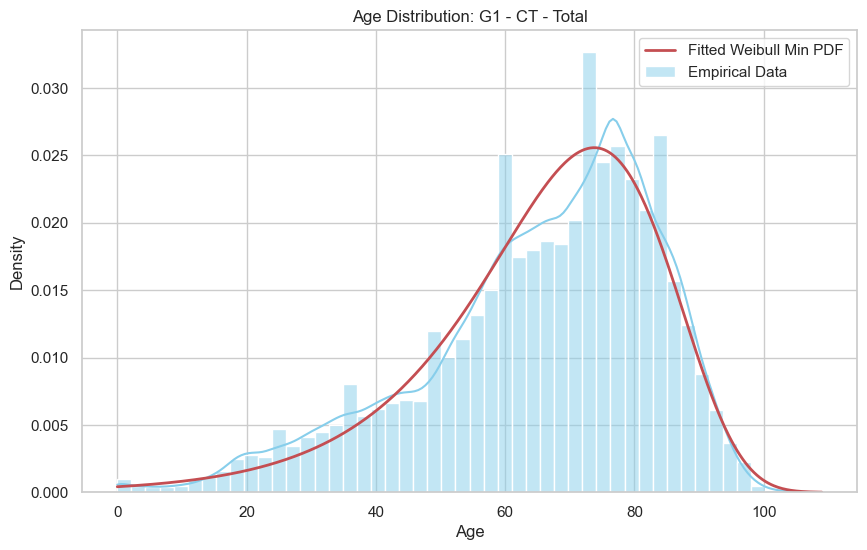

--- Generating plot for: G2 | MRI | Inpatient ---


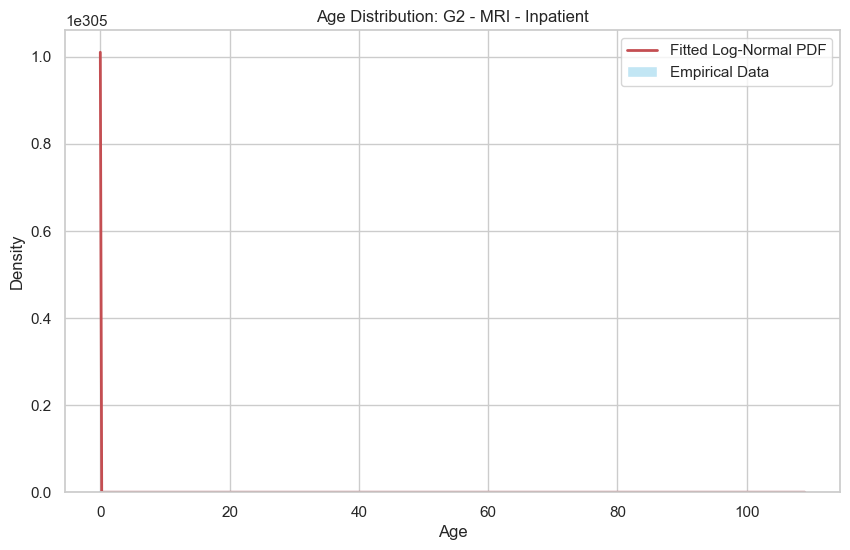

--- Generating plot for: G3 | MRI | Elective ---


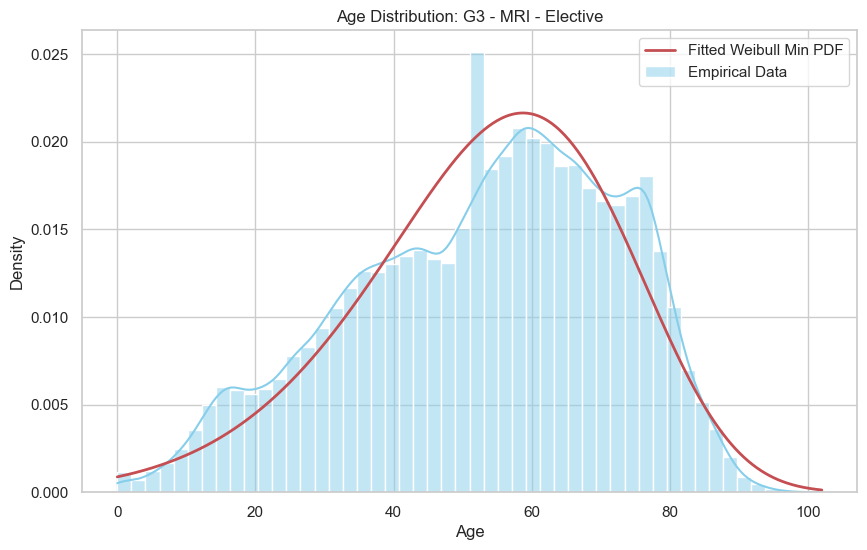

--- Generating plot for: G3 | MRI | Emergency ---


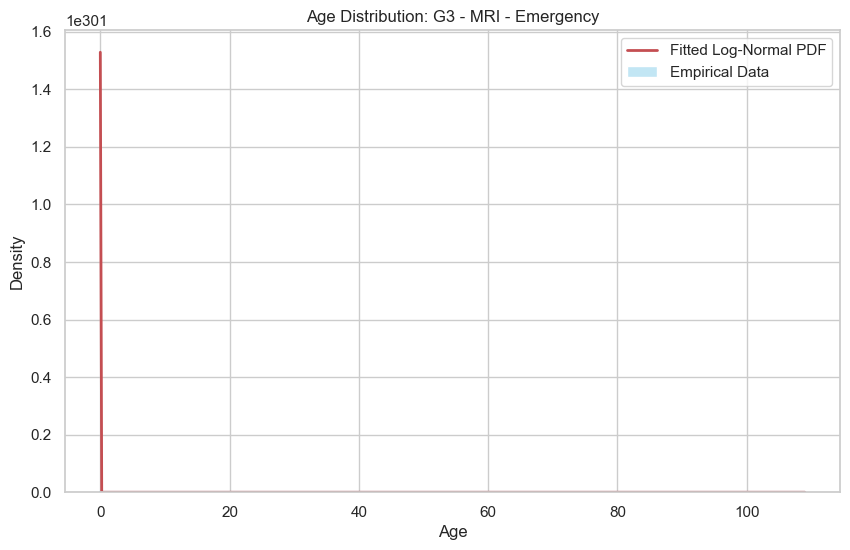

--- Generating plot for: G4 | CT | Cancer ---


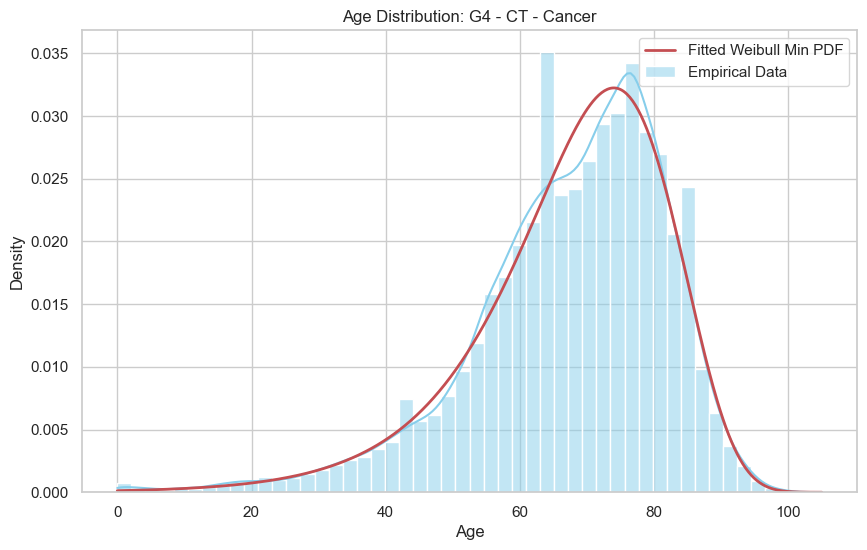

--- Generating plot for: G4 | CT | Non-Cancer ---


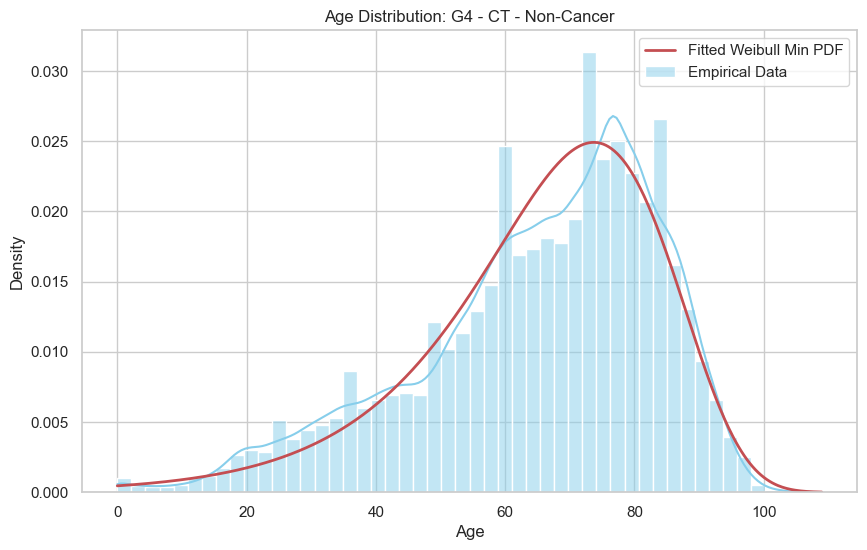

In [7]:
# --- Step 5.2: Visualize Key Models ---
# Based on the summary table, we can see interesting differences.
# For example, MRI demand for Inpatient and Emergency sources often follows a
# Log-Normal distribution, while most other pathways follow a Weibull Min.
# This section will automatically plot a few of these key comparisons.

# Define a list of interesting models to plot based on the summary results
key_models_to_visualize = [
    # Baseline: Total CT demand (typically a clear Weibull distribution)
    ('G1', 'CT', 'Total'),
    
    # Comparison: Inpatient MRI (often Log-Normal) vs. Elective MRI (often Weibull)
    ('G2', 'MRI', 'Inpatient'),
    ('G3', 'MRI', 'Elective'),
    
    # Comparison: Emergency MRI (often Log-Normal)
    ('G3', 'MRI', 'Emergency'),

    # Comparison: Cancer vs. Non-Cancer for a major modality
    ('G4', 'CT', 'Cancer'),
    ('G4', 'CT', 'Non-Cancer'),
]


# --- Plotting Logic ---
if 'df_clean' in locals() and not df_clean.empty and 'passed_df' in locals() and 'results_summary_df' in locals():
    
    # This dictionary maps the display names from our results to the actual scipy stats objects
    dist_objects = {
        'Normal': stats.norm,
        'Gamma': stats.gamma,
        'Log-Normal': stats.lognorm,
        'Weibull Min': stats.weibull_min
    }

    # --- Loop through the key models and plot them ---
    for group, modality, subgroup in key_models_to_visualize:
        print(f"--- Generating plot for: {group} | {modality} | {subgroup} ---")
        
        # Check if the chosen model passed the pre-fit checks before attempting to plot
        is_valid_model = not passed_df[
            (passed_df['Group'] == group) &
            (passed_df['Modality'] == modality) &
            (passed_df['Subgroup'] == subgroup)
        ].empty

        if not is_valid_model:
            print(f"Skipping plot for blocked or non-existent model: '{group} | {modality} | {subgroup}'")
            continue

        # 1. Get the data subset for the histogram
        df_mod = df_clean[df_clean["modality"] == modality]
        if group == 'G1': df_subset = group_filters['G1_Total'](df_mod)
        elif group == 'G2': df_subset = group_filters['G2_PatientSource'][subgroup](df_mod)
        elif group == 'G3': df_subset = group_filters[f'G3_{subgroup}'](df_mod)
        elif group == 'G4': df_subset = group_filters[f'G4_{subgroup}'](df_mod)
        else: continue
            
        age_data = df_subset['age'].dropna()
        if age_data.empty:
            print(f"No data to plot for '{group} | {modality} | {subgroup}'")
            continue

        # 2. Find the pre-computed results for this model from the summary DataFrame
        model_result = results_summary_df[
            (results_summary_df['Group'] == group) &
            (results_summary_df['Modality'] == modality) &
            (results_summary_df['Subgroup'] == subgroup)
        ]

        if model_result.empty:
            print(f"No fitting results found for '{group} | {modality} | {subgroup}'")
            continue

        # 3. Extract the best fit distribution name and its parameters
        best_fit_name = model_result.iloc[0]['Best_Fit_Dist']
        fit_params = model_result.iloc[0]['Parameters']
        dist = dist_objects.get(best_fit_name)

        if not dist:
            print(f"Distribution '{best_fit_name}' not found in mapping.")
            continue
            
        # 4. Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot the empirical data histogram
        sns.histplot(age_data, bins=50, kde=True, stat='density', color='skyblue', label='Empirical Data', ax=ax)
        
        # Plot the PDF of the fitted distribution using the stored parameters
        x = np.linspace(age_data.min(), age_data.max(), 500)
        pdf = dist.pdf(x, *fit_params)
        ax.plot(x, pdf, 'r-', lw=2, label=f'Fitted {best_fit_name} PDF')
        
        ax.set_title(f"Age Distribution: {group} - {modality} - {subgroup}")
        ax.set_xlabel('Age')
        ax.set_ylabel('Density')
        ax.legend()
        plt.show()

else:
    print("Clean DataFrame, passed_df, or results_summary_df not available. Cannot generate plots.")


In [17]:
# --------------------------------------------------------------
# Step 2: Aggregate raw demand counts by age, modality, and referral type
# --------------------------------------------------------------

# Group and count number of procedures per combination
grouped = df_clean.groupby(['age', 'modality', 'ps_bucket']).size().reset_index(name='procedure_count')

# Rename for clarity
final_df = grouped.rename(columns={'ps_bucket': 'referral_type'})

# Reorder columns
final_df = final_df[['age', 'modality', 'referral_type', 'procedure_count']]

print(f"Created raw demand table: {len(final_df):,} rows.")
display(final_df.head())


Created raw demand table: 1,293 rows.


,age,modality,referral_type,procedure_count
0,0.0,CT,Emergency,212
1,0.0,CT,GP,2
2,0.0,CT,Inpatient,443
3,0.0,CT,Other/Unknown,25
4,0.0,CT,Outpatient,103


In [19]:
# --------------------------------------------------------------
# FINAL STEP: Export modality–age–referral demand table for use in Notebook 07
# --------------------------------------------------------------

from pathlib import Path

# Define export path
export_path = Path("../data/processed/demand_distributions")
export_path.mkdir(parents=True, exist_ok=True)

# Define output file path
output_file = export_path / "modality_demand_by_age_and_source.csv"

# Define required column set for export
required_cols = {'age', 'modality', 'referral_type', 'procedure_count'}

try:
    # Ensure final_df exists and has correct structure
    if 'final_df' not in locals():
        raise NameError("Variable 'final_df' is not defined.")

    actual_cols = set(final_df.columns)
    if not required_cols.issubset(actual_cols):
        raise ValueError(f"'final_df' is missing required columns. Found: {actual_cols}")

    # Export CSV
    final_df.to_csv(output_file, index=False)
    print(f"Demand table exported successfully to:\n{output_file.resolve()}")

except Exception as e:
    print(f"Failed to export demand table: {e}")


Demand table exported successfully to:
/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed/demand_distributions/modality_demand_by_age_and_source.csv


## 6. Conclusions

This analysis has systematically fitted statistical distributions to age-based demand across various patient pathways. The summary table provides the best-fit distribution (based on AIC) for each valid combination of modality and subgroup.

**Key Insights:**
- **Pathway-Specific Shapes:** The age distribution of demand varies significantly depending on the patient pathway. For example, emergency demand often has a different shape (e.g., more bimodal or skewed) compared to elective GP-led demand.
- **Dominant Distributions:** Across many pathways, distributions like **Gamma** and **Log-Normal** often provide a better fit than a standard Normal distribution, accurately capturing the right-skew commonly seen in healthcare age data (i.e., demand increasing with age).

**Recommendations:**
1.  **Use Pathway-Specific Parameters:** For forecasting and simulation models (like in notebook `06`), use the specific distribution and its fitted parameters from the `distribution_fit_summary.csv` file for the relevant pathway. This will yield more accurate, localized predictions than a single, total-demand model.
2.  **Investigate Bimodality:** In cases where no single distribution fits well (indicated by high AIC values or visual inspection of on-demand plots), the underlying data may be bimodal or multimodal. This suggests two or more distinct patient groups are being combined. Further subgroup analysis (e.g., by specific procedure or gender) may be required to isolate these groups.

In [16]:
df_clean['age'].value_counts().sort_index().loc[0.0]


np.int64(1784)